In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

%config InlineBackend.figure_format = 'svg'

/home/joshuacp/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/joshuacp/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
path = '../../../../ruairidh/model_results/run_1/saves/csvs/'
csv_fns = [_ for _ in os.listdir(path) if '.csv' in _]
print(csv_fns[0])

vgg_15_BN_64_con_False_lr_0.01_seed_1_scores.csv


In [7]:
def parse_filenames(filenames):
    model_specs = []
    
    for filename in filenames:
        model_spec = {}
        model_spec['csv'] = filename

        model_spec['model_name'] = filename[:filename.find('con')-1]
        filename = filename[filename.find('con')+4:]
        if filename[:filename.find('_')]=='False':
            model_spec['human'] = True
        else:
            model_spec['human'] = False
        filename = filename[filename.find('lr_')+3:]
        model_spec['lr'] = float(filename[:filename.find('_')])
        filename = filename[filename.find('seed')+5:]
        model_spec['seed'] = int(filename[:filename.find('_')])
            
        model_specs.append(model_spec)
    
    return model_specs

print(parse_filenames(csv_fns)[0])

{'csv': 'vgg_15_BN_64_con_False_lr_0.01_seed_1_scores.csv', 'model_name': 'vgg_15_BN_64', 'human': True, 'lr': 0.01, 'seed': 1}


In [8]:
model_specs = parse_filenames(csv_fns)

In [9]:
# merge all data into one big pandas df
for i, model_spec in enumerate(model_specs):
    
    # read csv
    current_df = pd.read_csv(os.path.join(path, model_spec['csv']))
    if current_df.shape[0] < 101:
        size_warning = 'WARNING: '
        size_warning += model_spec['model_name']+' only has '+str(current_df.shape[0])+'/100 epochs'
        print(size_warning)
        
    # add meta to current csv
    for key in model_spec.keys():
        if key != 'csv': 
            current_df[key] = model_spec[key]
            
    if i == 0:
        df = current_df.copy()
    else:
        df = pd.concat([df, current_df])
        
df = df.reset_index()

In [10]:
print(df.keys())
df.head()

Index(['index', 'epoch', 'c10h_train_loss', 'c10h_train_acc', 'c10h_val_loss',
       'c10h_val_acc', 'c10h_train_c10_loss', 'c10h_train_c10_acc',
       'c10h_val_c10_loss', 'c10h_val_c10_acc', 'v4_loss', 'v4_acc', 'v6_loss',
       'v6_acc', 'c10_50k_loss', 'c10_50k_acc', 'model_name', 'human', 'lr',
       'seed'],
      dtype='object')


,index,epoch,c10h_train_loss,c10h_train_acc,c10h_val_loss,c10h_val_acc,c10h_train_c10_loss,c10h_train_c10_acc,c10h_val_c10_loss,c10h_val_c10_acc,v4_loss,v4_acc,v6_loss,v6_acc,c10_50k_loss,c10_50k_acc,model_name,human,lr,seed
0,0,0,0.794967,0.919556,0.776351,0.945,0.369321,0.920111,0.297674,0.947,0.838030,0.834240,0.788210,0.8535,0.002137,0.99956,vgg_15_BN_64,True,0.01,1
1,1,1,0.463000,0.920000,0.478384,0.922,0.236204,0.920667,0.227456,0.924,0.615054,0.818902,0.562245,0.8395,0.039436,0.99158,vgg_15_BN_64,True,0.01,1
2,2,2,0.358241,0.933444,0.383376,0.932,0.198980,0.934556,0.206034,0.934,0.508731,0.831766,0.467999,0.8475,0.068284,0.99380,vgg_15_BN_64,True,0.01,1
3,3,3,0.331081,0.942444,0.367047,0.934,0.182635,0.943000,0.205339,0.936,0.510393,0.833251,0.455903,0.8460,0.070515,0.99418,vgg_15_BN_64,True,0.01,1
4,4,4,0.319080,0.945222,0.362204,0.934,0.171912,0.946000,0.203533,0.935,0.505392,0.837209,0.454368,0.8430,0.068090,0.99454,vgg_15_BN_64,True,0.01,1


In [12]:
benchmark_data = []

for mn in df.model_name.unique()[::-1]:
    
    for ht in [True, False]:

        if ht:
            idxmin = df[(df.model_name==mn) & (df.human==ht)].c10h_val_loss.idxmin()
        else:
            idxmin = df[(df.model_name==mn) & (df.human==ht)].c10h_val_c10_loss.idxmin()
            print
            
        row = dict(df[(df.model_name==mn) & (df.human==ht)].loc[idxmin])
        del row['index']
        benchmark_data.append(row)
        
        hp_selector = (df.model_name==mn) & \
                      (df.human==ht) & \
                      (df.lr==row['lr']) & \
                      (df.seed==row['seed']) & \
                      (df.epoch==0)
        ep0_row = dict(df[hp_selector].reset_index().loc[0])
        del ep0_row['index'], ep0_row['level_0']
        benchmark_data.append(ep0_row)

b_df = pd.DataFrame(benchmark_data)
b_df

,c10_50k_acc,c10_50k_loss,c10h_train_acc,c10h_train_c10_acc,c10h_train_c10_loss,c10h_train_loss,c10h_val_acc,c10h_val_c10_acc,c10h_val_c10_loss,c10h_val_loss,epoch,human,lr,model_name,seed,v4_acc,v4_loss,v6_acc,v6_loss
0,0.98352,0.093114,0.987444,0.983444,0.066106,0.195256,0.949,0.949,0.166645,0.315630,47,True,0.010,densenet_BC_100_12,0,0.867392,0.401294,0.8775,0.377961
1,0.99998,0.000641,0.941111,0.943222,0.212312,0.627269,0.961,0.962,0.147656,0.613540,0,True,0.010,densenet_BC_100_12,0,0.883226,0.505212,0.8890,0.541001
2,0.99974,0.002901,0.969000,0.973000,0.071200,0.491760,0.957,0.958,0.135619,0.565883,4,False,0.001,densenet_BC_100_12,0,0.881247,0.456320,0.8855,0.491156
3,0.99998,0.000641,0.941111,0.943222,0.212312,0.627269,0.961,0.962,0.147656,0.613540,0,False,0.001,densenet_BC_100_12,0,0.883226,0.505212,0.8890,0.541001
4,0.99548,0.057687,0.985222,0.982889,0.074920,0.216723,0.957,0.959,0.132949,0.280957,6,True,0.010,wrn_28_10_cutout16,0,0.882731,0.366981,0.8890,0.335018
5,0.99998,0.001012,0.951000,0.953111,0.164471,0.463454,0.960,0.963,0.139544,0.452306,0,True,0.010,wrn_28_10_cutout16,0,0.895101,0.380155,0.9025,0.377669
6,0.99990,0.003035,0.968000,0.972222,0.074275,0.365051,0.962,0.965,0.110163,0.419722,2,False,0.001,wrn_28_10_cutout16,1,0.889164,0.370680,0.9005,0.345901
7,0.99998,0.001012,0.949333,0.952000,0.173595,0.466305,0.964,0.966,0.124278,0.467991,0,False,0.001,wrn_28_10_cutout16,1,0.895101,0.380155,0.9025,0.377669
8,0.92996,0.226056,0.990111,0.985778,0.062004,0.193356,0.925,0.925,0.237135,0.362633,100,True,0.100,resnet_basic_110,1,0.821376,0.557528,0.8165,0.542124
9,0.99976,0.002832,0.920667,0.922222,0.312123,0.721923,0.939,0.938,0.292607,0.777623,0,True,0.100,resnet_basic_110,1,0.846116,0.660880,0.8545,0.737634


In [160]:
# genereate latex table

# \begin{center}
# \begin{tabular}{ c c c }
#  cell1 & cell2 & cell3 \\ 
#  cell4 & cell5 & cell6 \\  
#  cell7 & cell8 & cell9    
# \end{tabular}
# \end{center}

# score_keys = [col for col in b_df.columns if 'c10' in col]
# print(score_keys)



def insert_str(idx, string, add):
    return string[:idx] + add + string[idx:]

# recursive function to make 
# underscores latex compatible
def fix_underscores(string):
    idx = string.find('_')
    if idx == -1: 
        return
    else:
        string = insert_str(string.find('_'), string, '\\')
        up_to = string[:string.find('_')+1]
        after = string[string.find('_')+1:]
        if after.find('_') == -1: return up_to+after
        new_string = up_to + fix_underscores(after)
        return new_string

# print(fix_underscores('c10h_val_loss'))


ordered_keys = ['c10h_val_loss', 'c10h_val_acc',
                'c10h_val_c10_loss', 'c10h_val_c10_acc',
                'v4_loss', 'v4_acc','v6_loss', 'v6_acc',               
                'c10_50k_loss', 'c10_50k_acc']

# print a table give two conditions (epoch, human)
def print_table(b_df, human, epoch):
    for mn in b_df.model_name.unique()[::-1]:
        print('\\texttt{'+fix_underscores(mn)+'}', end=' & ')

        row_select = (b_df.model_name==mn)&(b_df.human==human)&epoch
        row_data = b_df[row_select]

        for k, key in enumerate(ordered_keys):
            end = ' & '
            if k == len(ordered_keys) - 1: end = ' \\\\\n'

            if (k+1)%2 != 0:
                print(('%.2f' % row_data[key].values[0])[1:], end=' ')
            else:
                acc = row_data[key].values[0]*100
                print(('(%.0f' % acc ) + '\\%)', end=end)

In [174]:
loss_header = '& c10h val. & c10 val. & c10.1 v4 & c10.1 v6 & c10 50k \\\\'

print('\\begin{center}')
print('\\begin{tabular}{ l l l l l l }')

print("\multicolumn{6}{c}{Pretrained on \\texttt{CIFAR10}}\\\\")
print("\hline  \\\\ [-2.2ex]")
print(loss_header)
print("\hline  \\\\ [-2.1ex]")

print_table(b_df, False, (b_df.epoch==0))
print("\hline \\\\")

# print("[2ex]")
print("\multicolumn{6}{c}{Fine-tuned on \\texttt{CIFAR10}}\\\\")
print("\hline  \\\\ [-2.2ex]")
print(loss_header)
print("\hline  \\\\ [-2.1ex]")

print_table(b_df, False, (b_df.epoch!=0))
print("\hline \\\\")

# print("[2ex]")
print("\multicolumn{6}{c}{Fine-tuned on \\texttt{CIFAR10H}}\\\\")
print("\hline  \\\\ [-2.2ex]")
print(loss_header)
print("\hline  \\\\ [-2.1ex]")

print_table(b_df, True, (b_df.epoch!=0))
print("\hline \\\\")

print('\\end{tabular}')
print('\\end{center}')

\begin{center}
\begin{tabular}{ l l l l l l }
\multicolumn{6}{c}{Pretrained on \texttt{CIFAR10}}\\
\hline  \\ [-2.2ex]
& c10h val. & c10 val. & c10.1 v4 & c10.1 v6 & c10 50k \\
\hline  \\ [-2.1ex]
\texttt{vgg\_15\_BN\_64} & .78 (94\%) & .30 (95\%) & .84 (83\%) & .79 (85\%) & .00 (100\%) \\
\texttt{resnext\_29\_8x64d} & .44 (96\%) & .12 (96\%) & .34 (89\%) & .34 (89\%) & .02 (100\%) \\
\texttt{wrn\_28\_10} & .44 (96\%) & .15 (96\%) & .40 (90\%) & .38 (91\%) & .00 (100\%) \\
\texttt{resnet\_basic\_110} & .78 (94\%) & .29 (94\%) & .66 (85\%) & .74 (85\%) & .00 (100\%) \\
\texttt{wrn\_28\_10\_cutout16} & .47 (96\%) & .12 (97\%) & .38 (90\%) & .38 (90\%) & .00 (100\%) \\
\texttt{densenet\_BC\_100\_12} & .61 (96\%) & .15 (96\%) & .51 (88\%) & .54 (89\%) & .00 (100\%) \\
\hline \\
\multicolumn{6}{c}{Fine-tuned on \texttt{CIFAR10}}\\
\hline  \\ [-2.2ex]
& c10h val. & c10 val. & c10.1 v4 & c10.1 v6 & c10 50k \\
\hline  \\ [-2.1ex]
\texttt{vgg\_15\_BN\_64} & .50 (93\%) & .21 (93\%) & .66 (82\%) 

In [8]:
# colors= ['blue','red']

# plt.figure(figsize=(12,8), dpi=150)

# for plot_i, loss_key in enumerate(['c10h_val_loss', 'c10h_val_c10_loss', 'v4_loss', 'v6_loss']):
#     plt.subplot(2, 2, plot_i+1)
#     for m, mn in enumerate(b_df.model_name.unique()[::-1]):

#         for h, human in enumerate([True, False]):
#             start = b_df[(b_df.model_name==mn)&(b_df.human==human)&(b_df.epoch==0)][loss_key].values[0]
#             end = b_df[(b_df.model_name==mn)&(b_df.human==human)&(b_df.epoch!=0)][loss_key].values[0]

#             extra = 0.25
#             if h==1: extra=0.45
#             space = 1.0
#             x = m*space-1+extra

# #             plt.plot([x, x], [start, end], color=colors[h], linewidth=1, zorder=-999)
# #             plt.scatter(x, end, marker='o', color='white', s=40, edgecolor=colors[h])
#             plt.annotate('', xy=(x, end), xytext=(x, start+0.008), 
#                          arrowprops={'arrowstyle': '->', 'color':colors[h], 'lw':1.0}, 
#                          va='center')
#             plt.scatter(x, start, marker='_', color=None, s=0, edgecolor=None)
#             plt.ylim([0.08,0.87])
#             plt.title(loss_key)

#     if plot_i % 2 == 0: plt.ylabel('Crossentropy', fontsize=14)

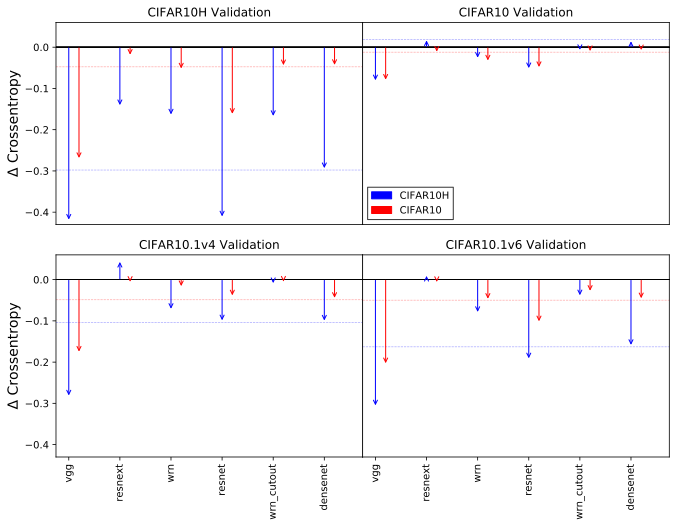

In [73]:
colors= ['blue','red']

plt.figure(figsize=(11,8), dpi=200)

titles = ['CIFAR10H Validation', 'CIFAR10 Validation', 
          'CIFAR10.1v4 Validation', 'CIFAR10.1v6 Validation']

# print(b_df.model_name.unique()[::-1]) # leave for updating!
model_names = ['vgg_15_BN_64', 'resnext_29_8x64d', 'wrn_28_10', 
               'resnet_basic_110',
               'wrn_28_10_cutout16', 'densenet_BC_100_12']
model_names_fixed = ['vgg', 'resnext', 'wrn', 'resnet', 'wrn_cutout', 'densenet']

for plot_i, loss_key in enumerate(['c10h_val_loss', 'c10h_val_c10_loss', 'v4_loss', 'v6_loss']):
    plt.subplot(2, 2, plot_i+1)
    xs = []
    for m, mn in enumerate(b_df.model_name.unique()[::-1]):
        human_mags = []
        nonhuman_mags = []

        for h, human in enumerate([True, False]):
            
            start = b_df[(b_df.model_name==mn)&(b_df.human==human)&(b_df.epoch==0)][loss_key].values[0]
            end = b_df[(b_df.model_name==mn)&(b_df.human==human)&(b_df.epoch!=0)][loss_key].values[0]

            extra = 0.25
            if h==1: extra=0.45
            space = 1.0
            x = m*space-1+extra
            
            mag = end - start
            if human: 
                human_mags.append(mag)
                xs.append(x)
            else:
                nonhuman_mags.append(mag)

            if mag < 0: 
                plt.annotate('', xy=(x, mag), xytext=(x, 0.003), 
                             arrowprops={'arrowstyle': '->', 'color':colors[h], 'lw':1.0}, 
                             va='center')
            else:
                plt.annotate('', xy=(x, mag), xytext=(x, -0.003), 
                             arrowprops={'arrowstyle': '->', 'color':colors[h], 'lw':1.0}, 
                             va='center')
            plt.scatter(x, mag, marker='_', color=None, s=0, edgecolor=None)
        
            plt.plot([-1, 5], [0, 0], color='black', linewidth=0.6, zorder=-999)
            plt.ylim([-0.43, 0.06])
            plt.xlim([-1, 5])
            plt.title(titles[plot_i]) #loss_key)
            
    plt.plot([-1, 5], [np.mean(human_mags), np.mean(human_mags)], '--', color='blue',
             linewidth=0.6, zorder=-999, alpha=0.4)
    plt.plot([-1, 5], [np.mean(nonhuman_mags), np.mean(nonhuman_mags)], '--', color='red',
             linewidth=0.6, zorder=-999, alpha=0.4)
    if plot_i % 2 == 0: 
        plt.ylabel('$\mathit{\Delta}$ Crossentropy', fontsize=14)
    else:
        plt.gca().axes.get_yaxis().set_visible(False)
    
    if plot_i > 1: 
        plt.xticks(xs, model_names_fixed, rotation='vertical')
    else:
        plt.tick_params(
            axis='x',
            which='both',
            bottom=False,
            top=False,
            labelbottom=False)
    
    if plot_i==1: 
#         custom_lines = [Line2D([0], [0], color='red', lw=5),
#                         Line2D([0], [0], color='blue', lw=5)]
#         plt.legend(custom_lines, ['CIFAR10H Training', 'CIFAR10H Training'],
#                   loc='lower right')
        human_patch = mpatches.Patch(color='blue', label='CIFAR10H')
        nonh_patch = mpatches.Patch(color='red', label='CIFAR10')

        plt.legend(handles=[human_patch, nonh_patch], 
                   fancybox=False, edgecolor='black')
        
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.15)

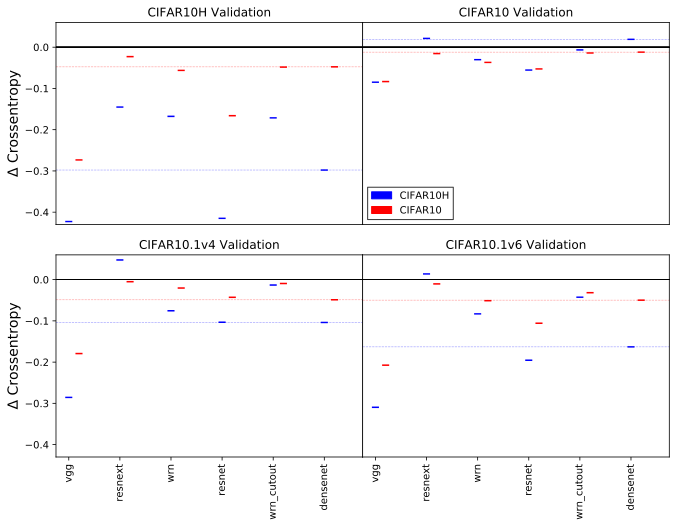

In [78]:
colors= ['blue','red']

plt.figure(figsize=(11,8), dpi=200)

titles = ['CIFAR10H Validation', 'CIFAR10 Validation', 
          'CIFAR10.1v4 Validation', 'CIFAR10.1v6 Validation']

# print(b_df.model_name.unique()[::-1]) # leave for updating!
model_names = ['vgg_15_BN_64', 'resnext_29_8x64d', 'wrn_28_10', 
               'resnet_basic_110',
               'wrn_28_10_cutout16', 'densenet_BC_100_12']
model_names_fixed = ['vgg', 'resnext', 'wrn', 'resnet', 'wrn_cutout', 'densenet']

for plot_i, loss_key in enumerate(['c10h_val_loss', 'c10h_val_c10_loss', 'v4_loss', 'v6_loss']):
    plt.subplot(2, 2, plot_i+1)
    xs = []
    for m, mn in enumerate(b_df.model_name.unique()[::-1]):
        human_mags = []
        nonhuman_mags = []

        for h, human in enumerate([True, False]):
            
            start = b_df[(b_df.model_name==mn)&(b_df.human==human)&(b_df.epoch==0)][loss_key].values[0]
            end = b_df[(b_df.model_name==mn)&(b_df.human==human)&(b_df.epoch!=0)][loss_key].values[0]

            extra = 0.25
            if h==1: extra=0.45
            space = 1.0
            x = m*space-1+extra
            
            mag = end - start
            if human: 
                human_mags.append(mag)
                xs.append(x)
            else:
                nonhuman_mags.append(mag)

            plt.scatter(x, mag, marker='_', facecolor=colors[h], s=50, edgecolor=None)
        
            plt.plot([-1, 5], [0, 0], color='black', linewidth=0.6, zorder=-999)
            plt.ylim([-0.43, 0.06])
            plt.xlim([-1, 5])
            plt.title(titles[plot_i]) #loss_key)
            
    plt.plot([-1, 5], [np.mean(human_mags), np.mean(human_mags)], '--', color='blue',
             linewidth=0.6, zorder=-999, alpha=0.4)
    plt.plot([-1, 5], [np.mean(nonhuman_mags), np.mean(nonhuman_mags)], '--', color='red',
             linewidth=0.6, zorder=-999, alpha=0.4)
    if plot_i % 2 == 0: 
        plt.ylabel('$\mathit{\Delta}$ Crossentropy', fontsize=14)
    else:
        plt.gca().axes.get_yaxis().set_visible(False)
    
    if plot_i > 1: 
        plt.xticks(xs, model_names_fixed, rotation='vertical')
    else:
        plt.tick_params(
            axis='x',
            which='both',
            bottom=False,
            top=False,
            labelbottom=False)
    
    if plot_i==1: 
        human_patch = mpatches.Patch(color='blue', label='CIFAR10H')
        nonh_patch = mpatches.Patch(color='red', label='CIFAR10')

        plt.legend(handles=[human_patch, nonh_patch], 
                   fancybox=False, edgecolor='black')
        
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.15)